In [8]:
#Code borrowed from Gilles Poulain  
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

from ast import literal_eval
from datetime import datetime, timedelta
import os, random

# Plotting geographical data
import folium
from folium import plugins
import rasterio as rio
import rasterstats
import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

#Code borrowed from Gilles Poulain 
global_power_plants = pd.read_csv('./eie_data-2/gppd/gppd_120_pr.csv')
global_power_plants.head(3)

,system:index,capacity_mw,commissioning_year,country,country_long,estimated_generation_gwh,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,...,other_fuel1,other_fuel2,other_fuel3,owner,primary_fuel,source,url,wepp_id,year_of_capacity_data,.geo
0,0000000000000000315a,15.0,1942.0,USA,United States of America,685.397712,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PREPA,Hydro,CEPR,http://energia.pr.gov/datos/plantas/,30936.0,0,"{""type"":""Point"",""coordinates"":[-66.66629863706..."
1,000000000000000026e5,1492.0,1975.0,USA,United States of America,8334.010812,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/aguirre.asp,30928.0,0,"{""type"":""Point"",""coordinates"":[-66.23079607357..."
2,00000000000000002fda,990.0,1962.0,USA,United States of America,5529.940150,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/costasur.asp,30934.0,0,"{""type"":""Point"",""coordinates"":[-66.75340271704..."


In [9]:
# Columns with only 0 or NaN values
relevant_cols = ['name','capacity_mw','commissioning_year','estimated_generation_gwh','owner','primary_fuel','wepp_id','.geo','gppd_idnr']
pr_plants = global_power_plants[relevant_cols]
pr_plants.head()

,name,capacity_mw,commissioning_year,estimated_generation_gwh,owner,primary_fuel,wepp_id,.geo,gppd_idnr
0,Dos Bocas,15.0,1942.0,685.397712,PREPA,Hydro,30936.0,"{""type"":""Point"",""coordinates"":[-66.66629863706...",WRI1026827
1,Aguirre,1492.0,1975.0,8334.010812,PREPA,Oil,30928.0,"{""type"":""Point"",""coordinates"":[-66.23079607357...",WRI1026809
2,Costa Sur,990.0,1962.0,5529.940150,PREPA,Oil,30934.0,"{""type"":""Point"",""coordinates"":[-66.75340271704...",WRI1026811
3,Palo Seco,602.0,1960.0,3362.650475,PREPA,Oil,30942.0,"{""type"":""Point"",""coordinates"":[-66.14859700475...",WRI1026814
4,Carite 1,10.0,1915.0,456.931808,PREPA,Hydro,65289.0,"{""type"":""Point"",""coordinates"":[-66.10600367149...",WRI1026821


In [10]:
def get_lon_from_geo(str_):
    dict_ = literal_eval(str_)
    coordinates = dict_['coordinates']
    lon = coordinates[0]
    return lon

def get_lat_from_geo(str_):
    dict_ = literal_eval(str_)
    coordinates = dict_['coordinates']
    lat = coordinates[1]
    return lat

pr_plants['lon'] = pr_plants['.geo'].map(get_lon_from_geo)
pr_plants['lat'] = pr_plants['.geo'].map(get_lat_from_geo)

pr_plants.drop(columns=['.geo'], inplace=True)

geometry_pr_plants = [Point(x,y) for x,y in zip(pr_plants['lon'], pr_plants['lat'])]
pr_plants_gdf = gpd.GeoDataFrame(pr_plants, crs = {'init': 'epsg: 4326'}, geometry = geometry_pr_plants)

# from https://www.kaggle.com/maxlenormand/simplified-emission-for-each-plant-wip
buffered_pr_plants = pr_plants.copy()
buffered_pr_plants['geometry'] = pr_plants_gdf.geometry.buffer(0.05)

pr_plants.head(3)

,name,capacity_mw,commissioning_year,estimated_generation_gwh,owner,primary_fuel,wepp_id,gppd_idnr,lon,lat
0,Dos Bocas,15.0,1942.0,685.397712,PREPA,Hydro,30936.0,WRI1026827,-66.666299,18.335899
1,Aguirre,1492.0,1975.0,8334.010812,PREPA,Oil,30928.0,WRI1026809,-66.230796,17.951899
2,Costa Sur,990.0,1962.0,5529.940150,PREPA,Oil,30934.0,WRI1026811,-66.753403,18.000298


In [11]:
df_fossil = pr_plants[(pr_plants.primary_fuel == 'Oil')|(pr_plants.primary_fuel == 'Gas')]
df_renew = pr_plants[(pr_plants.primary_fuel == 'Hydro')|(pr_plants.primary_fuel == 'Solar')|(pr_plants.primary_fuel == 'Wind')]

In [23]:
df_fossil

,name,capacity_mw,commissioning_year,estimated_generation_gwh,owner,primary_fuel,wepp_id,gppd_idnr,lon,lat
1,Aguirre,1492.0,1975.0,8334.010812,PREPA,Oil,30928.0,WRI1026809,-66.230796,17.951899
2,Costa Sur,990.0,1962.0,5529.940150,PREPA,Oil,30934.0,WRI1026811,-66.753403,18.000298
3,Palo Seco,602.0,1960.0,3362.650475,PREPA,Oil,30942.0,WRI1026814,-66.148597,18.455301
10,Aguirre,42.0,0.0,295.909706,NaN,Gas,NaN,WRI1028012,-66.231202,17.953300
11,Yabucoa,42.0,0.0,295.909706,NaN,Gas,30951.0,WRI1028014,-65.824897,18.106398
12,Costa Sur,42.0,0.0,295.909706,NaN,Gas,NaN,WRI1028011,-66.753701,18.001801
13,Daguao,42.0,0.0,295.909706,NaN,Gas,30937.0,WRI1028013,-65.667701,18.232502
14,EcoEléctrica,507.0,0.0,3572.052879,Gas Natural Fenosa International Power,Gas,18991.0,WRI1026812,-66.755204,17.981200
15,Jobos,42.0,0.0,295.909706,NaN,Gas,30940.0,WRI1028010,-66.140196,17.961500
16,Mayagüez,220.0,0.0,1550.003222,NaN,Gas,30941.0,WRI1028007,-67.160006,18.219401


In [24]:
df_renew

,name,capacity_mw,commissioning_year,estimated_generation_gwh,owner,primary_fuel,wepp_id,gppd_idnr,lon,lat
0,Dos Bocas,15.000000,1942.0,685.397712,PREPA,Hydro,30936.0,WRI1026827,-66.666299,18.335899
4,Carite 1,10.000000,1915.0,456.931808,PREPA,Hydro,65289.0,WRI1026821,-66.106004,18.044702
5,Toro Negro 1,8.640000,1929.0,394.789082,PREPA,Hydro,30950.0,WRI1026823,-66.487899,18.131802
6,Garzas 1,7.200000,1941.0,328.990902,PREPA,Hydro,30938.0,WRI1026825,-66.734594,18.094100
7,Garzas 2,5.040000,1941.0,230.293631,PREPA,Hydro,49078.0,WRI1026826,-66.730501,18.072701
8,Toro Negro 2,1.920000,1937.0,87.730907,PREPA,Hydro,30949.0,WRI1026824,-66.511595,18.166400
9,San Fermin Solar Farm,27.000000,0.0,12.040047,NaN,Solar,66179.0,WRI1028017,-65.907699,18.405501
20,Yauco 1,25.000000,0.0,1142.329520,NaN,Hydro,30952.0,WRI1026828,-66.871101,18.110599
21,Caonillas 1,18.000000,0.0,822.477254,NaN,Hydro,30933.0,WRI1028015,-66.643205,18.296102
22,Caonillas 2,3.600000,0.0,164.495451,NaN,Hydro,30932.0,WRI1028016,-66.669099,18.239699


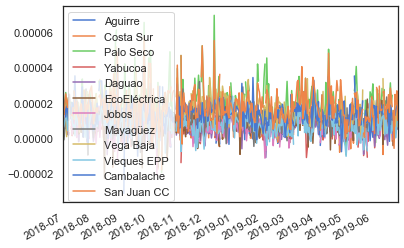

In [25]:
sentinel_path = "./eie_data-2/s5p_no2/"
s5p_files = os.listdir(sentinel_path)
s5p_dates = [datetime.strptime(g[:16], 's5p_no2_%Y%m%d') for g in s5p_files]

ctr = 0 
for city_name in df_fossil.name:
    ctr += 1
    df_plant = pr_plants_gdf[pr_plants_gdf['name'] == city_name]

    dates = []
    stats = []
    for s5p_file in s5p_files:
        image_path = sentinel_path + s5p_file
        date = datetime.strptime(s5p_file[:16], 's5p_no2_%Y%m%d')
        stat = rasterstats.zonal_stats(df_plant.geometry.to_json(),
                                       image_path,
                                       band=2, #2: tropospheric_NO2_column_number_density
                                       stats=['mean'])
        stat = stat[0] # get location of pp
        stat = stat['mean'] # retrieve stat
        dates.append(date)
        stats.append(stat)
    if ctr == 1:
        results = pd.DataFrame(index=dates, data=stats, columns=[city_name])
    else: 
        results[city_name] = stats
results.plot()

<Figure size 504x936 with 0 Axes>

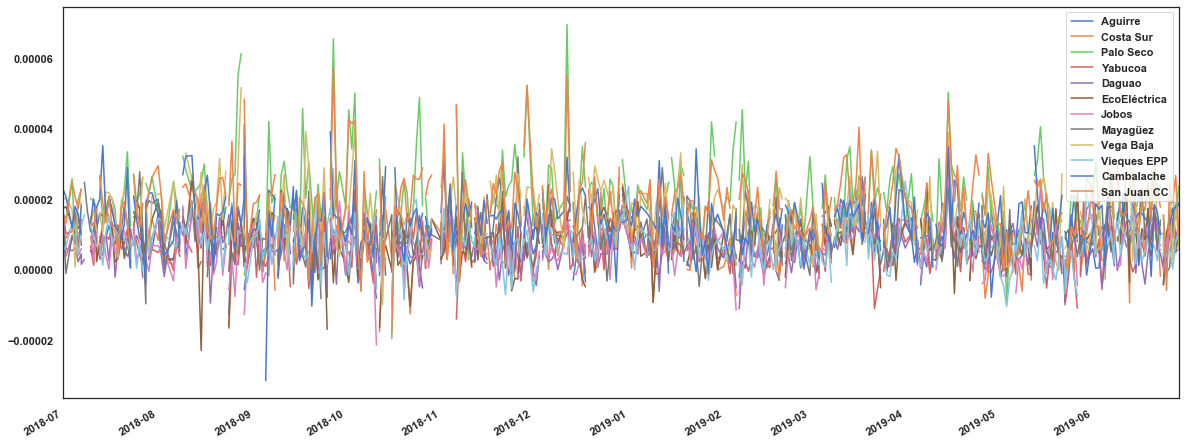

In [33]:
import matplotlib
import matplotlib.pyplot as plt

fossil_results = results

fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(7,13)
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "bold"
plt.rcParams["figure.figsize"] = (20,8)
fossil_results.plot()

In [34]:
ctr = 0 
for city_name in df_renew.name:
    ctr += 1
    df_plant = pr_plants_gdf[pr_plants_gdf['name'] == city_name]

    dates = []
    stats = []
    for s5p_file in s5p_files:
        image_path = sentinel_path + s5p_file
        date = datetime.strptime(s5p_file[:16], 's5p_no2_%Y%m%d')
        stat = rasterstats.zonal_stats(df_plant.geometry.to_json(),
                                       image_path,
                                       band=2, #2: tropospheric_NO2_column_number_density
                                       stats=['mean'])
        stat = stat[0] # get location of pp
        stat = stat['mean'] # retrieve stat
        dates.append(date)
        stats.append(stat)
    if ctr == 1:
        results = pd.DataFrame(index=dates, data=stats, columns=[city_name])
    else: 
        results[city_name] = stats

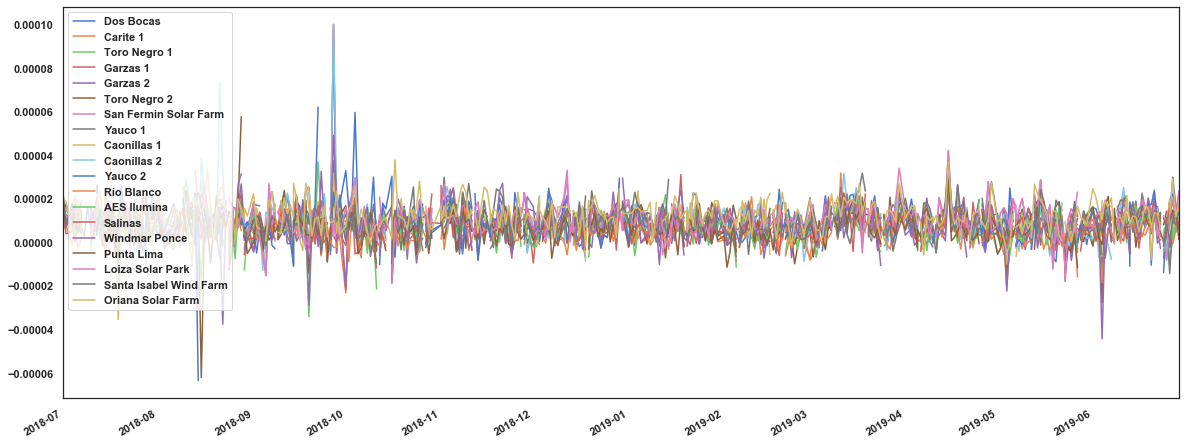

In [36]:
renewable_results = results
renewable_results = renewable_results.mask(renewable_results > 0.0001, 0.0001)
renewable_results.plot()

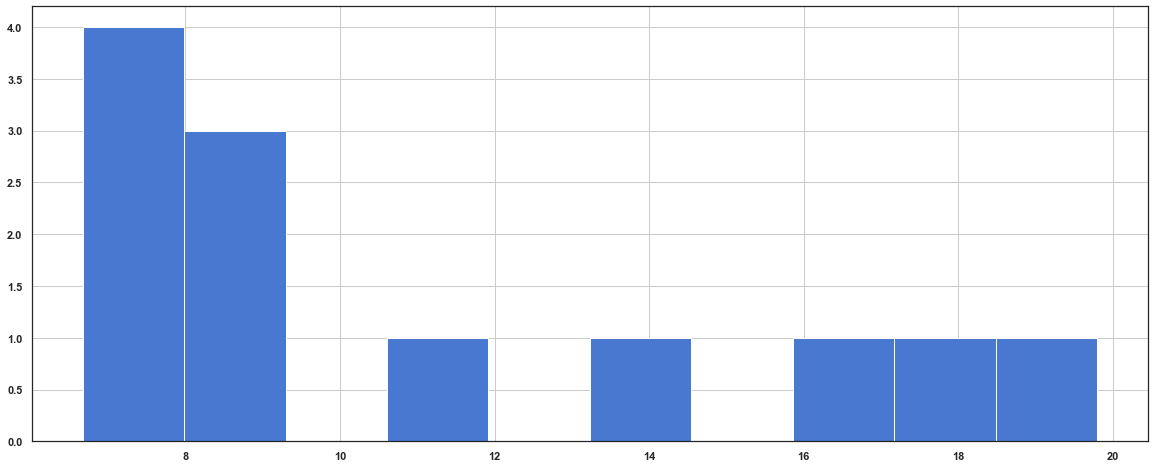

In [41]:
(fossil_results.mean()*1000000).hist()

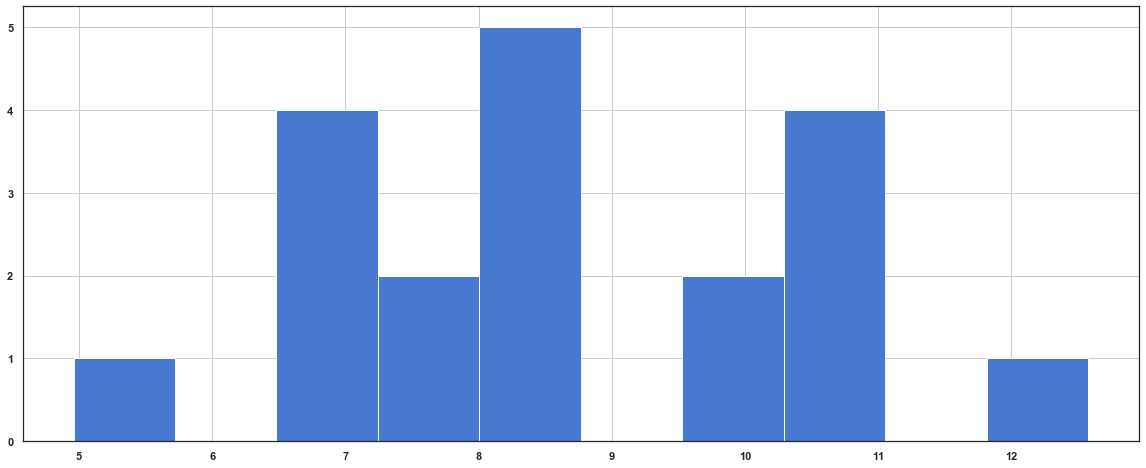

In [42]:
(renewable_results.mean()*1000000).hist()

In [43]:
#Despite fossil plants having slightly higher overall mean, 
#there is no significant trend between emissions and weather season or plant type (fossil & renewable). 
#Other factors such as population size might
#play a far greater role, making it difficult to isolate plant's emission impact 